In [30]:
# -*- coding: utf-8 -*-
import warnings

warnings.filterwarnings(action='ignore')
import os, sys
import pandas as pd
import numpy as np
import math

def importOwnLib():
    if '/home/miruware/aProjects/lib' not in sys.path:
        sys.path.append('/home/miruware/aProjects/lib')
        print("lib path is successfully appended.")
    else:
        print("lib path is already exists.")

importOwnLib()
import sonyalib as sonya

import importlib
importlib.reload(sonya)

import datetime
import timeit

from scipy import interp

import keras
from keras import backend as K
from keras.optimizers import Adam
from keras import callbacks, losses
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
# import argparse
# import locale
from keras import initializers

import matplotlib.pyplot as plt
import tensorflow as tf
# %matplotlib inline # jupyter 에서만 사용

## RFE
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV, StratifiedKFold,train_test_split, KFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc, roc_curve
from sklearn.pipeline import Pipeline

from sklearn.metrics import auc, roc_curve  # plot_roc_curve


lib path is already exists.


In [56]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True # GPU메모리가 전부 할당되지 않고, 아주 적은 비율만 할당되어 시작해서 프로세스의 메모리 수요에 따라 증가하게 된다.
config.gpu_options.visible_device_list = "0"
K.set_session(tf.Session(config=config))


def mlp_model(num_input = 0, dropout=0, learning_rate=0.005, neuron1=9, neuron2=9):
    global num_features
    num_input = num_features
    keras.backend.clear_session()
    ## 모델 구성하기
    seed_number = 7
    model = Sequential()
    # print learning rate

    model.add(Dense(neuron1, activation='relu', input_dim=num_input, kernel_initializer=initializers.he_normal(seed=seed_number)))
    model.add(BatchNormalization())
    model.add(Dense(neuron2, activation='relu', kernel_initializer=initializers.he_normal(seed=seed_number)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=initializers.he_normal(seed=seed_number)))

    ## 모델 컴파일
    model.compile(optimizer=Adam(learning_rate), loss=losses.binary_crossentropy, metrics=['accuracy'])

    # model.summary()
    return model
def confusion_metrics(conf_matrix):
    # save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)

    # calculate accuracy
    conf_accuracy = (float(TP + TN) / float(TP + TN + FP + FN))

    # calculate mis-classification
    conf_misclassification = 1 - conf_accuracy

    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))

    # calculate precision
    conf_precision = (TN / float(TN + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-' * 50)
    print(f'Accuracy: {round(conf_accuracy, 2)}')
    print(f'Mis-Classification: {round(conf_misclassification, 2)}')
    print(f'Sensitivity: {round(conf_sensitivity, 2)}')
    print(f'Specificity: {round(conf_specificity, 2)}')
    print(f'Precision: {round(conf_precision, 2)}')
    print(f'f_1 Score: {round(conf_f1, 2)}')

    return conf_sensitivity,  conf_specificity


In [43]:
def createmodel(n_layers, first_layer_nodes, last_layer_nodes, learning_rates ,activation_func, loss_func):
    model = Sequential()
    n_nodes = FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes)
    for i in range(1, n_layers):
        if i==1:
            model.add(Dense(first_layer_nodes, input_dim=X_train.shape[1], activation=activation_func))
        else:
            model.add(Dense(n_nodes[i-1], activation=activation_func))
            
    #Finally, the output layer should have a single node in binary classification
    model.add(Dense(1, activation=activation_func))
    model.compile(optimizer= Adam(learning_rates), loss=loss_func, metrics = ["accuracy"]) #note: metrics could also be 'mse'
    
    return model

##Wrap model into scikit-learn
model =  KerasClassifier(build_fn=createmodel, verbose = False)  

In [37]:
def FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes):
    layers = []
    nodes_increment = (last_layer_nodes - first_layer_nodes) / (n_layers-1)
    nodes = first_layer_nodes
    for i in range(1, n_layers+1):
        layers.append(math.ceil(nodes))
        nodes = nodes + nodes_increment
    
    return layers

In [38]:
activation_funcs = ['relu'] 
loss_funcs = ['binary_crossentropy']
param_grid = dict(n_layers=[2],
                  learning_rates = [0.1, 0.05],
                  first_layer_nodes = [9,11], 
                  last_layer_nodes = [9,11],
                  activation_func = activation_funcs,
                  loss_func = loss_funcs,
                  batch_size = [25],
                  epochs = [20])

 Current num of properties: 18
18/18 [==============================] - 0s 115us/step
./normalized_rfe_3/base_mode_RFE_test00_PR18/10_AUC58_20210628-162324.h5
./normalized_rfe_3/base_mode_RFE_test00_PR18/10_AUC58_20210628-162324.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR18/10_AUC58_20210628-162324.h5 .json/h5
0.09449112415313721
0.11445164680480957
0.21367788314819336
0.05487477779388428
0.4304819405078888
0.1764501929283142
0.04377007484436035
0.24741891026496887
0.01145261526107788
0.1325901746749878
0.3011436462402344
0.0013911724090576172
0.3633638620376587
0.36889004707336426
0.5524847209453583
0.23194116353988647
0.17048412561416626
0.34491345286369324
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR18/1_AUC35_20210628-161820.h5
./normalized_rfe_3/base_mode_RFE_test00_PR18/1_AUC35_20210628-161820.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR18/1_AUC35_20210628-161820.h5 .json/h5
0.23893913626670837
0.16255903

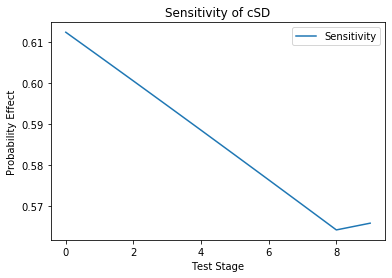

 Current num of properties: 17
18/18 [==============================] - 0s 121us/step
./normalized_rfe_3/base_mode_RFE_test00_PR17/10_AUC75_20210628-163824.h5
./normalized_rfe_3/base_mode_RFE_test00_PR17/10_AUC75_20210628-163824.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR17/10_AUC75_20210628-163824.h5 .json/h5
0.1875208616256714
0.05545264482498169
0.21941637992858887
0.11364030838012695
0.15603655576705933
0.09975147247314453
0.05224233865737915
0.0651235580444336
0.13696950674057007
0.3638243079185486
0.06767892837524414
0.11980438232421875
0.23804384469985962
0.22373610734939575
0.2710018754005432
0.16814130544662476
0.04927206039428711
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR17/1_AUC61_20210628-163319.h5
./normalized_rfe_3/base_mode_RFE_test00_PR17/1_AUC61_20210628-163319.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR17/1_AUC61_20210628-163319.h5 .json/h5
0.2850140333175659
0.10650286078453064
0.346554636

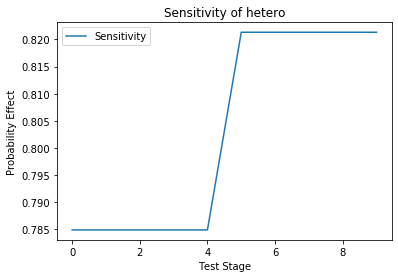

 Current num of properties: 16
18/18 [==============================] - 0s 118us/step
./normalized_rfe_3/base_mode_RFE_test00_PR16/10_AUC78_20210628-165229.h5
./normalized_rfe_3/base_mode_RFE_test00_PR16/10_AUC78_20210628-165229.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR16/10_AUC78_20210628-165229.h5 .json/h5
0.17658919095993042
0.0749659538269043
0.2962743639945984
0.003958761692047119
0.07163798809051514
0.06751012802124023
0.050826430320739746
0.03377753496170044
0.10512346029281616
0.4031437039375305
0.1362326741218567
0.07570749521255493
0.0068094730377197266
0.12853574752807617
0.21715092658996582
0.12129604816436768
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR16/1_AUC66_20210628-164723.h5
./normalized_rfe_3/base_mode_RFE_test00_PR16/1_AUC66_20210628-164723.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR16/1_AUC66_20210628-164723.h5 .json/h5
0.2273566722869873
0.19280987977981567
0.5073938071727753
0.056620

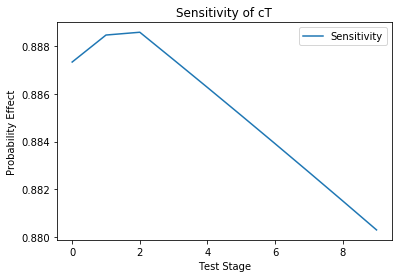

 Current num of properties: 15
18/18 [==============================] - 0s 116us/step
./normalized_rfe_3/base_mode_RFE_test00_PR15/10_AUC89_20210628-170536.h5
./normalized_rfe_3/base_mode_RFE_test00_PR15/10_AUC89_20210628-170536.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR15/10_AUC89_20210628-170536.h5 .json/h5
0.4855581820011139
0.009274899959564209
0.5759660601615906
0.2274230718612671
0.017424046993255615
0.00984114408493042
0.05597639083862305
0.03210413455963135
0.03352862596511841
0.04133254289627075
0.017183661460876465
0.028434336185455322
0.02490377426147461
0.062035441398620605
0.1299222707748413
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR15/1_AUC52_20210628-170035.h5
./normalized_rfe_3/base_mode_RFE_test00_PR15/1_AUC52_20210628-170035.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR15/1_AUC52_20210628-170035.h5 .json/h5
0.4475802183151245
0.030985713005065918
0.47249549627304077
0.23242628574371338
0.100

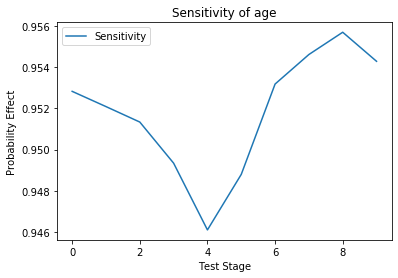

 Current num of properties: 14
18/18 [==============================] - 0s 131us/step
./normalized_rfe_3/base_mode_RFE_test00_PR14/10_AUC70_20210628-171858.h5
./normalized_rfe_3/base_mode_RFE_test00_PR14/10_AUC70_20210628-171858.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR14/10_AUC70_20210628-171858.h5 .json/h5
0.24899691343307495
0.2629621624946594
0.02218616008758545
0.03955256938934326
0.006422102451324463
0.018668413162231445
0.12422168254852295
0.06534743309020996
0.00946044921875
0.009461045265197754
0.0186767578125
0.005497932434082031
0.0439380407333374
0.022022008895874023
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR14/1_AUC83_20210628-171354.h5
./normalized_rfe_3/base_mode_RFE_test00_PR14/1_AUC83_20210628-171354.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR14/1_AUC83_20210628-171354.h5 .json/h5
0.41269052028656006
0.9002534747123718
0.09420371055603027
0.12444531917572021
0.02780294418334961
0.088055670

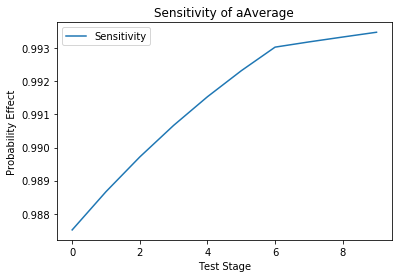

 Current num of properties: 13
18/18 [==============================] - 0s 134us/step
./normalized_rfe_3/base_mode_RFE_test00_PR13/10_AUC90_20210628-173152.h5
./normalized_rfe_3/base_mode_RFE_test00_PR13/10_AUC90_20210628-173152.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR13/10_AUC90_20210628-173152.h5 .json/h5
0.07543516159057617
0.6563380155712366
0.6817968487739563
0.3463592827320099
0.696147233247757
0.8181541003286839
0.88475102186203
0.07244211435317993
0.26587241888046265
0.2927892804145813
0.32285889983177185
0.4480746388435364
0.8590192557312548
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR13/1_AUC64_20210628-172649.h5
./normalized_rfe_3/base_mode_RFE_test00_PR13/1_AUC64_20210628-172649.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR13/1_AUC64_20210628-172649.h5 .json/h5
0.03132539987564087
0.6110339462757111
0.6465847492218018
0.040338337421417236
0.6350784599781036
0.7957957834005356
0.9093883037567139
0.

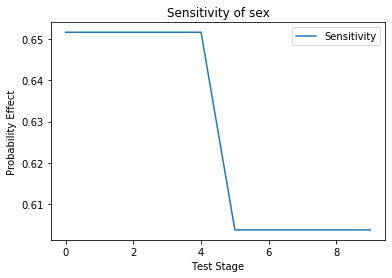

 Current num of properties: 12
18/18 [==============================] - 0s 122us/step
./normalized_rfe_3/base_mode_RFE_test00_PR12/10_AUC78_20210628-174344.h5
./normalized_rfe_3/base_mode_RFE_test00_PR12/10_AUC78_20210628-174344.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR12/10_AUC78_20210628-174344.h5 .json/h5
0.1995503306388855
0.4762587249279022
0.07158440351486206
0.03237426280975342
0.03586900234222412
0.22098225355148315
0.06116396188735962
0.07869446277618408
0.17814171314239502
0.2402108907699585
0.18979525566101074
0.15825122594833374
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR12/1_AUC50_20210628-173842.h5
./normalized_rfe_3/base_mode_RFE_test00_PR12/1_AUC50_20210628-173842.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR12/1_AUC50_20210628-173842.h5 .json/h5
0.3501388132572174
0.7349596619606018
0.11637717485427856
0.11265945434570312
0.13903069496154785
0.09977203607559204
0.1532631516456604
0.5877201855

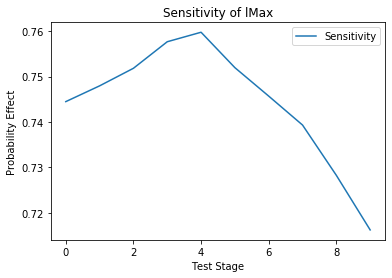

 Current num of properties: 11
18/18 [==============================] - 0s 129us/step
./normalized_rfe_3/base_mode_RFE_test00_PR11/10_AUC83_20210628-175440.h5
./normalized_rfe_3/base_mode_RFE_test00_PR11/10_AUC83_20210628-175440.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR11/10_AUC83_20210628-175440.h5 .json/h5
0.012997329235076904
0.4262685775756836
0.09249883890151978
0.21973669528961182
0.3070184588432312
0.5013906694948673
0.12844038009643555
0.17132866382598877
0.30319464206695557
0.21666890382766724
0.0747184157371521
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR11/1_AUC57_20210628-174938.h5
./normalized_rfe_3/base_mode_RFE_test00_PR11/1_AUC57_20210628-174938.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR11/1_AUC57_20210628-174938.h5 .json/h5
0.02069169282913208
0.4688124358654022
0.17100238800048828
0.23793745040893555
0.340186208486557
0.42067465744912624
0.08276033401489258
0.3146185278892517
0.19370275735

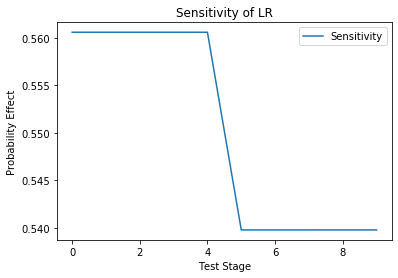

 Current num of properties: 10
18/18 [==============================] - 0s 125us/step
./normalized_rfe_3/base_mode_RFE_test00_PR10/10_AUC83_20210628-180538.h5
./normalized_rfe_3/base_mode_RFE_test00_PR10/10_AUC83_20210628-180538.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR10/10_AUC83_20210628-180538.h5 .json/h5
0.6701815724372864
0.5299623310565948
0.32615798711776733
0.5549061596393585
0.2368265688419342
0.4618528485298157
0.5985957980155945
0.5617683678865433
0.607867568731308
0.5319259464740753
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR10/1_AUC71_20210628-180036.h5
./normalized_rfe_3/base_mode_RFE_test00_PR10/1_AUC71_20210628-180036.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR10/1_AUC71_20210628-180036.h5 .json/h5
0.3676968812942505
0.8575457744300365
0.26587677001953125
0.8130676746368408
0.23695630580186844
0.6893775761127472
0.6799024641513824
0.3876517713069916
0.844413697719574
0.6821993887424469
-----

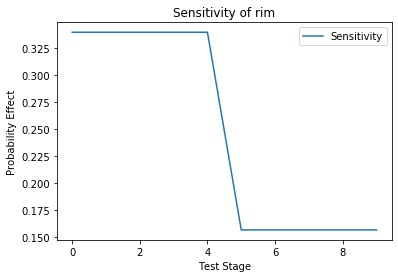

 Current num of properties: 9
18/18 [==============================] - 0s 111us/step
./normalized_rfe_3/base_mode_RFE_test00_PR9/10_AUC87_20210628-181619.h5
./normalized_rfe_3/base_mode_RFE_test00_PR9/10_AUC87_20210628-181619.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR9/10_AUC87_20210628-181619.h5 .json/h5
0.3904668092727661
0.2297874093055725
0.31260329484939575
0.5212208330631256
0.36592918634414673
0.23692476749420166
0.24535122513771057
0.08138459920883179
0.12894368171691895
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR9/1_AUC65_20210628-181114.h5
./normalized_rfe_3/base_mode_RFE_test00_PR9/1_AUC65_20210628-181114.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR9/1_AUC65_20210628-181114.h5 .json/h5
0.1438155174255371
0.5816451907157898
0.9067634642124176
0.9576044082641602
0.5676842033863068
0.41545143723487854
0.3738032281398773
0.5405657887458801
0.3665004372596741
------------------------
./normalized_rfe_3/

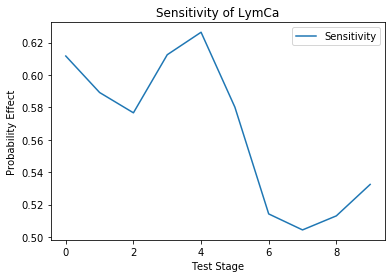

 Current num of properties: 8
18/18 [==============================] - 0s 122us/step
./normalized_rfe_3/base_mode_RFE_test00_PR8/10_AUC86_20210628-182613.h5
./normalized_rfe_3/base_mode_RFE_test00_PR8/10_AUC86_20210628-182613.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR8/10_AUC86_20210628-182613.h5 .json/h5
0.5369412302970886
0.13909286260604858
0.2277248501777649
0.38483792543411255
0.29265516996383667
0.3826739192008972
0.1635345220565796
0.10674113035202026
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR8/1_AUC71_20210628-182109.h5
./normalized_rfe_3/base_mode_RFE_test00_PR8/1_AUC71_20210628-182109.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR8/1_AUC71_20210628-182109.h5 .json/h5
0.7596485763788223
0.5523093640804291
0.4844403862953186
0.7550959587097168
0.07167628407478333
0.03327932953834534
0.14165779948234558
0.4872402995824814
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR8/2_AUC76_20210

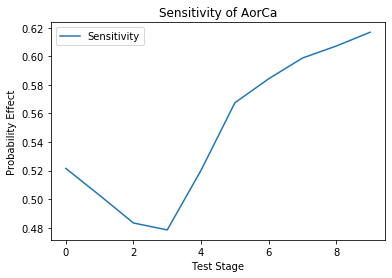

 Current num of properties: 7
18/18 [==============================] - 0s 112us/step
./normalized_rfe_3/base_mode_RFE_test00_PR7/10_AUC92_20210628-183537.h5
./normalized_rfe_3/base_mode_RFE_test00_PR7/10_AUC92_20210628-183537.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR7/10_AUC92_20210628-183537.h5 .json/h5
0.6052259504795074
0.28397876024246216
0.26988157629966736
0.628628134727478
0.16650056838989258
0.13659745454788208
0.18852770328521729
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR7/1_AUC65_20210628-183032.h5
./normalized_rfe_3/base_mode_RFE_test00_PR7/1_AUC65_20210628-183032.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR7/1_AUC65_20210628-183032.h5 .json/h5
0.8595902919769287
0.6243726760149002
0.577454149723053
0.8523216247558594
0.07645595073699951
0.3380752503871918
0.33107730746269226
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR7/2_AUC72_20210628-183106.h5
./normalized_rfe_3/base_mo

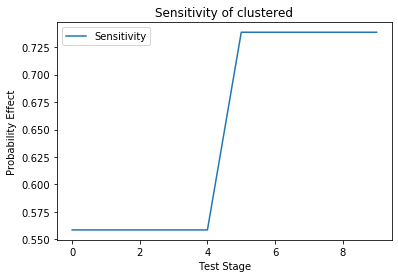

 Current num of properties: 6
18/18 [==============================] - 0s 130us/step
./normalized_rfe_3/base_mode_RFE_test00_PR6/10_AUC87_20210628-184431.h5
./normalized_rfe_3/base_mode_RFE_test00_PR6/10_AUC87_20210628-184431.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR6/10_AUC87_20210628-184431.h5 .json/h5
0.7268633246421814
0.5361645445227623
0.41123002767562866
0.5002309381961823
0.44990307092666626
0.44325780868530273
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR6/1_AUC61_20210628-183928.h5
./normalized_rfe_3/base_mode_RFE_test00_PR6/1_AUC61_20210628-183928.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR6/1_AUC61_20210628-183928.h5 .json/h5
0.5757670104503632
0.5187255442142487
0.6967864632606506
0.8212357759475708
0.051699429750442505
0.49359244108200073
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR6/2_AUC80_20210628-184002.h5
./normalized_rfe_3/base_mode_RFE_test00_PR6/2_AUC80_20210628-18

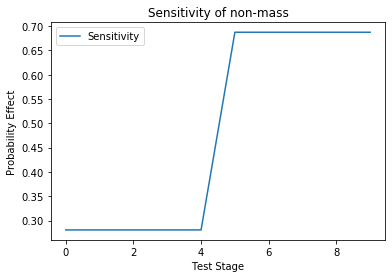

 Current num of properties: 5
18/18 [==============================] - 0s 118us/step
./normalized_rfe_3/base_mode_RFE_test00_PR5/10_AUC92_20210628-185248.h5
./normalized_rfe_3/base_mode_RFE_test00_PR5/10_AUC92_20210628-185248.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR5/10_AUC92_20210628-185248.h5 .json/h5
0.5424514412879944
0.3778521716594696
0.19339662790298462
0.2948666214942932
0.20120388269424438
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR5/1_AUC78_20210628-184745.h5
./normalized_rfe_3/base_mode_RFE_test00_PR5/1_AUC78_20210628-184745.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR5/1_AUC78_20210628-184745.h5 .json/h5
0.464495450258255
0.3993728458881378
0.5960584282875061
0.9373780786991119
0.4541763961315155
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR5/2_AUC79_20210628-184819.h5
./normalized_rfe_3/base_mode_RFE_test00_PR5/2_AUC79_20210628-184819.json
Loaded model from disk ./normaliz

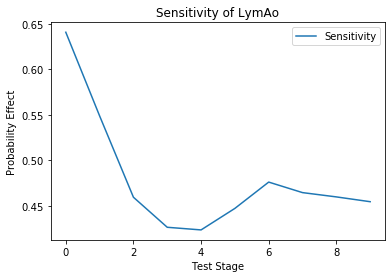

 Current num of properties: 4
18/18 [==============================] - 0s 118us/step
./normalized_rfe_3/base_mode_RFE_test00_PR4/10_AUC90_20210628-190108.h5
./normalized_rfe_3/base_mode_RFE_test00_PR4/10_AUC90_20210628-190108.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR4/10_AUC90_20210628-190108.h5 .json/h5
0.5397364795207977
0.3365055322647095
0.40004849433898926
0.5506007075309753
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR4/1_AUC32_20210628-185604.h5
./normalized_rfe_3/base_mode_RFE_test00_PR4/1_AUC32_20210628-185604.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR4/1_AUC32_20210628-185604.h5 .json/h5
0.3976408839225769
0.4517545998096466
0.6266356110572815
0.6798956990242004
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR4/2_AUC52_20210628-185638.h5
./normalized_rfe_3/base_mode_RFE_test00_PR4/2_AUC52_20210628-185638.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR4/2_AU

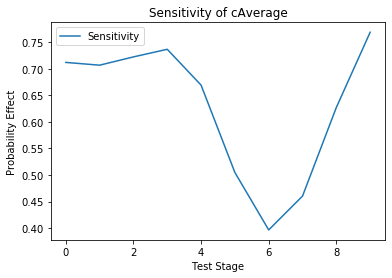

 Current num of properties: 3
18/18 [==============================] - 0s 125us/step
./normalized_rfe_3/base_mode_RFE_test00_PR3/10_AUC90_20210628-190911.h5
./normalized_rfe_3/base_mode_RFE_test00_PR3/10_AUC90_20210628-190911.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR3/10_AUC90_20210628-190911.h5 .json/h5
0.5245461761951447
0.40403154492378235
0.2757311463356018
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR3/1_AUC65_20210628-190407.h5
./normalized_rfe_3/base_mode_RFE_test00_PR3/1_AUC65_20210628-190407.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR3/1_AUC65_20210628-190407.h5 .json/h5
0.7347683981060982
0.34101763367652893
0.4531570076942444
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR3/2_AUC59_20210628-190441.h5
./normalized_rfe_3/base_mode_RFE_test00_PR3/2_AUC59_20210628-190441.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR3/2_AUC59_20210628-190441.h5 .json/h5
0.773

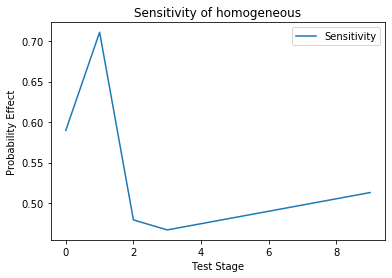

 Current num of properties: 2
18/18 [==============================] - 0s 116us/step
./normalized_rfe_3/base_mode_RFE_test00_PR2/10_AUC78_20210628-191653.h5
./normalized_rfe_3/base_mode_RFE_test00_PR2/10_AUC78_20210628-191653.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR2/10_AUC78_20210628-191653.h5 .json/h5
0.603381872177124
0.06928670406341553
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR2/1_AUC54_20210628-191148.h5
./normalized_rfe_3/base_mode_RFE_test00_PR2/1_AUC54_20210628-191148.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR2/1_AUC54_20210628-191148.h5 .json/h5
0.9684455655515194
0.6954896450042725
------------------------
./normalized_rfe_3/base_mode_RFE_test00_PR2/2_AUC82_20210628-191222.h5
./normalized_rfe_3/base_mode_RFE_test00_PR2/2_AUC82_20210628-191222.json
Loaded model from disk ./normalized_rfe_3/base_mode_RFE_test00_PR2/2_AUC82_20210628-191222.h5 .json/h5
0.9564988017082214
0.5956203043460846
-------

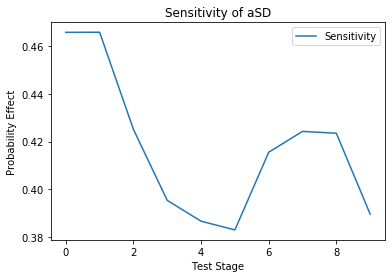

 Current num of properties: 1
18/18 [==============================] - 0s 123us/step
['cN']


In [82]:
start_time = timeit.default_timer()  # 시작 시간 체크
# ==== Step 1. Load original dataset
file_path0 = './BRC_input_201116_train.xlsx'
file_path1 = './BRC_input_201116_test.xlsx'
meta_train = sonya.get_normalized_metadata(file_path0)
meta_test = sonya.get_normalized_metadata(file_path1)
PATH_model = './normalized_rfe_3'
sonya.createFolder(PATH_model)

properties = [  # total 18
    'sex',
    'age',
    'LR',
    'cT',
    'cN',
    'cAverage',
    'cSD',
    'aAverage',
    'aSD',
    'lMax',
    'homogeneous',
    'hetero',
    'rim',
    'clustered',
    'non-mass',
    'AorCa',
    'LymAo',
    'LymCa'
]
num_properties = len(properties)


for nf in range(num_properties):
    
    num_features = len(properties)
    target_dir = PATH_model + '/base_mode_RFE_test00_PR{}'.format(num_features)
    sonya.createFolder(target_dir)

    ## ========== get the new dataset of selected features ==========
    X_train = meta_train[properties]
    y_train = meta_train['label']

    X_test = meta_test[properties]
    y_test = meta_test['label']

    num_features = len(properties)  # update
    print('\033[31m \033[43m' + 'Current num of properties: ' + str(num_features) + '\033[0m')
    ## ========== >>>>>>>>>> optimize_hyperparameters <<<<<<<<<< ==========

    grid_result = GridSearchCV(estimator=model, param_grid=param_grid)
    grid_result.fit(X_train, y_train)

    best_lr = grid_result.best_params_.get('learning_rates')
    best_batch = grid_result.best_params_.get('batch_size')
    best_l1 = grid_result.best_params_.get('first_layer_nodes')
    best_l2 = grid_result.best_params_.get('last_layer_nodes')


    best_model = mlp_model(num_input=num_features, learning_rate= best_lr, neuron1=best_l1, neuron2=best_l2)

    kfold = StratifiedKFold(n_splits=10, shuffle=True)

    accuracy = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # K-fold cross validation
    # 학습 데이터를 이용해서 학습

    i = 1
    for train_index, validation_index in kfold.split(X_train,y_train):
        kX_train, kX_test = X_train.iloc[train_index], X_train.iloc[validation_index]
        ky_train, ky_test = y_train.iloc[train_index], y_train.iloc[validation_index]

        cbks = [callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 2)),
                callbacks.TensorBoard(write_graph=False)]


        best_model.fit(kX_train, ky_train, epochs=500, batch_size=best_batch, validation_data=(kX_test, ky_test),
                     callbacks=cbks, verbose=0)
        y_val_cat_prob = best_model.predict_proba(kX_test)

        k_accuracy = '%.4f' % (best_model.evaluate(kX_test, ky_test)[1])
        accuracy.append(k_accuracy)

        # roc curve
        fpr, tpr, t = roc_curve(y_train.iloc[validation_index], y_val_cat_prob)
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

 

        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        model_fold_name = target_dir + '/'+ str(i) + '_AUC' +str(int(float(roc_auc) * 100)) + "_" + current_time
        model_fold_json = best_model.to_json()

        with open('{}.json'.format(model_fold_name), 'w') as json_file:
            json_file.write(model_fold_json)  # save model per fold

        best_model.save_weights('{}.h5'.format(model_fold_name))  # save weight per fold

        i = i + 1

    with open("./normalized_rfe_3/auc_records.txt", "a") as file:
        auc_records = "PR{}_aucs = ".format(str(num_features)) + str(aucs)
        file.write(auc_records + "\n")
    
    if num_features == 1: # input 개수가 1 일경우 rfe 진행 x
        print(properties)
        with open("./normalized_rfe_3/eliminated_features.txt", "a") as file:
            file.write("{}\t{}\n".format(nf, properties))
        break
    
    # -------------------------------- rfe --------------------------------------
    '--------------------- load model --------------------------- '
    # ==================================================================

    from scipy.stats import zscore

    raw_data = X_train
    X_total = raw_data

    data_columns_size = X_train.columns.size

    numvars =  X_train.shape[1]

    x_sens_base2 = X_train.median()  # Column별 median
    x_sens_base = X_train.mean()  # Column별 median
    for seq_id in range(numvars):
        if len(X_train.iloc[:, seq_id].unique()) == 2:
            x_sens_base[seq_id] = 0  # Binary var는 0으로

    Sens_test_num = 10
    Pred_rx1 = np.zeros((Sens_test_num, len(x_sens_base)))  # 변수별 Sens_test결과 array
    # Pred_rx1 = pd.DataFrame()
    Pred_diff_stage = []

    min(X_train.iloc[:, 1])
    max(X_train.iloc[:, 1])

    X_train = np.array(X_train)


    # ========
    import os

    def list_files_subdir(destpath, ext):
        filelist = []
        for path, subdirs, files in os.walk(destpath):
            for filename in files:
                f = os.path.join(path, filename)
                if os.path.isfile(f):
                    if filename.endswith(ext):
                        filelist.append(f)
        filelist.sort()
        return filelist

    # filelist = list_files_subdir(strdirectory_fc, 'txt')
    h5_list = list_files_subdir(target_dir, 'h5')
    json_list = list_files_subdir(target_dir, 'json')
    # -------------------------------------------------------

    index_list = []
    value_list = []


    df_effect = pd.DataFrame(raw_data.columns)

    for i in range(len(h5_list)):
        index_list = []
        value_list = []
        print(h5_list[i])
        print(json_list[i])
        # load model & weights
        json_name = (json_list[i])
        json_file = open(json_name, "r")
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)

        h5_file = h5_list[i]
        loaded_model.load_weights(h5_file)
        print("Loaded model from disk", h5_file, ".json/h5")
        '--------------------- end of load model --------------------------- '
        sigma = 2
        for seq_id in range(numvars):
            # for seq_id in range(1):
            X_sens_test = np.tile(x_sens_base, (Sens_test_num, 1))  # Make test base
            if (len(np.unique(X_train[:, seq_id])) == 2):
                X_sens_test[(Sens_test_num // 2):, seq_id] = 1
            else:
                if sigma == -1:
                    X_sens_test[:, seq_id] = np.linspace(min(X_train[:, seq_id]),
                                                         max(X_train[:, seq_id]), Sens_test_num)
                elif sigma > 0:
                    x_avg = X_train[:, seq_id].mean();
                    x_sd = X_train[:, seq_id].std()
                    X_sens_test[:, seq_id] = np.linspace(x_avg - (sigma * x_sd), x_avg + (sigma * x_sd),
                                                         Sens_test_num)
            loaded_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
            y_pred = loaded_model.predict_proba(X_sens_test)
            # Pred_rx1.iloc[:, seq_id] = y_pred     # class를 기준으로 함
            Pred_rx1[:, seq_id] = y_pred[:, 0]  # '0' for sigmoid, '1' for softmax # class를 기준으로 함
            # y_pred_softmax = resto_sess.run(tf.nn.softmax(y_pred))    # Pred_rx0[:, seq_id] = y_pred_softmax[:, 0]
            Pred_diff = np.max(Pred_rx1[:, seq_id], axis=0) - np.min(Pred_rx1[:, seq_id], axis=0)
            Pred_diff_stage.append(Pred_diff)
            print(Pred_diff)
        print("------------------------")
        df_effect[1 + i] = Pred_diff_stage
        Pred_diff_stage = []

    df_effect[1 + numvars] = df_effect.mean(axis=1)
    df_effect[2 + numvars] = df_effect.std(axis=1)
    df_effect = df_effect.rename(columns={1 + numvars: 'mean'})
    df_effect = df_effect.rename(columns={2 + numvars: 'std'})
    df_effect1 = df_effect.sort_values(by=['mean'], axis=0)
    df_effect1['fNum'] = df_effect1.index
    df_effect1 = df_effect1.reset_index(drop=True)
    df_effect0 = df_effect1
    df_effect1 = df_effect1.filter([0, 'fNum', 'mean', 'std'])
    df_effect2 = df_effect1.filter([0, 'fNum', 'mean'])

    df_effect0.to_csv(target_dir + "/rfe" + '.txt')

    elim_idx, elim_pred_diff = min(enumerate(df_effect['mean']), key=lambda x: x[1])

    elim_fName = X_total.columns[elim_idx]
    print("Elim target : ", "#", elim_idx, " ", elim_fName, "w/ effect of ", elim_pred_diff)
    print(df_effect2)

    plt.plot(Pred_rx1[:, elim_idx], label='Sensitivity'.format(elim_pred_diff, elim_fName))
    plt.title('Sensitivity of {}'.format(elim_fName))
    plt.ylabel("Probability Effect")
    plt.xlabel("Test Stage")
    plt.legend(loc="best")
#     plt.savefig('./plot_normalized_meta/{}.Sensitivity of {}.png'.format(str(nf), elim_fName))
    plt.show()
#     plt.clf()
    
    with open("./normalized_rfe_3/eliminated_features.txt", "a") as file:
        file.write("{}\t{}\n".format(nf, elim_fName))
        
    properties.remove(elim_fName)


In [62]:
y_pred_proba = (best_model.predict(X_train) >= 0.693).astype(int)
cm = confusion_matrix(y_train, y_pred_proba)
print("Radiologist + AI")
print(cm)
confusion_metrics(cm)

Radiologist + AI
[[44 15]
 [39 98]]
True Positives: 98
True Negatives: 44
False Positives: 15
False Negatives: 39
--------------------------------------------------
Accuracy: 0.72
Mis-Classification: 0.28
Sensitivity: 0.72
Specificity: 0.75
Precision: 0.75
f_1 Score: 0.73


(0.7153284671532847, 0.7457627118644068)

In [80]:
    num_features = 1
    target_dir = PATH_model + '/base_mode_RFE_test00_PR{}'.format(num_features)
    sonya.createFolder(target_dir)

    ## ========== get the new dataset of selected features ==========
    X_train = meta_train['homogeneous']
    y_train = meta_train['label']

    X_test = meta_test['homogeneous']
    y_test = meta_test['label']

    num_features = len(properties)  # update
    print('\033[31m \033[43m' + 'Current num of properties: ' + str(num_features) + '\033[0m')
    ## ========== >>>>>>>>>> optimize_hyperparameters <<<<<<<<<< ==========

#     grid_result = GridSearchCV(estimator=model, param_grid=param_grid)
#     grid_result.fit(X_train, y_train)

#     best_lr = grid_result.best_params_.get('learning_rates')
#     best_batch = grid_result.best_params_.get('batch_size')
#     best_l1 = grid_result.best_params_.get('first_layer_nodes')
#     best_l2 = grid_result.best_params_.get('last_layer_nodes')


    best_model = mlp_model(num_input=num_features, learning_rate= 0.05, neuron1=11, neuron2=11)

    kfold = StratifiedKFold(n_splits=10, shuffle=True)

    accuracy = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # K-fold cross validation
    # 학습 데이터를 이용해서 학습

    i = 1
    for train_index, validation_index in kfold.split(X_train,y_train):
        kX_train, kX_test = X_train.iloc[train_index], X_train.iloc[validation_index]
        ky_train, ky_test = y_train.iloc[train_index], y_train.iloc[validation_index]

        cbks = [callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 2)),
                callbacks.TensorBoard(write_graph=False)]


        best_model.fit(kX_train, ky_train, epochs=500, batch_size=best_batch, validation_data=(kX_test, ky_test),
                     callbacks=cbks, verbose=0)
        y_val_cat_prob = best_model.predict_proba(kX_test)

        k_accuracy = '%.4f' % (best_model.evaluate(kX_test, ky_test)[1])
        accuracy.append(k_accuracy)

        # roc curve
        fpr, tpr, t = roc_curve(y_train.iloc[validation_index], y_val_cat_prob)
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

 

        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        model_fold_name = target_dir + '/'+ str(i) + '_AUC' +str(int(float(roc_auc) * 100)) + "_" + current_time
        model_fold_json = best_model.to_json()

        with open('{}.json'.format(model_fold_name), 'w') as json_file:
            json_file.write(model_fold_json)  # save model per fold

        best_model.save_weights('{}.h5'.format(model_fold_name))  # save weight per fold

        i = i + 1

    with open("./normalized_rfe_2/auc_records.txt", "a") as file:
        auc_records = "PR{}_aucs = ".format(str(num_features)) + str(aucs)
        file.write(auc_records + "\n")
    

 Current num of properties: 1
18/18 [==============================] - 0s 126us/step
